C:\Users\bindh\AppData\Local\Temp\ipykernel_21388\3447847176.py:83: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  messages_df['timestamp'] = pd.to_datetime(messages_df['timestamp'], errors='coerce')
C:\Users\bindh\AppData\Local\Temp\ipykernel_21388\3447847176.py:83: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  messages_df['timestamp'] = pd.to_datetime(messages_df['timestamp'], errors='coerce')


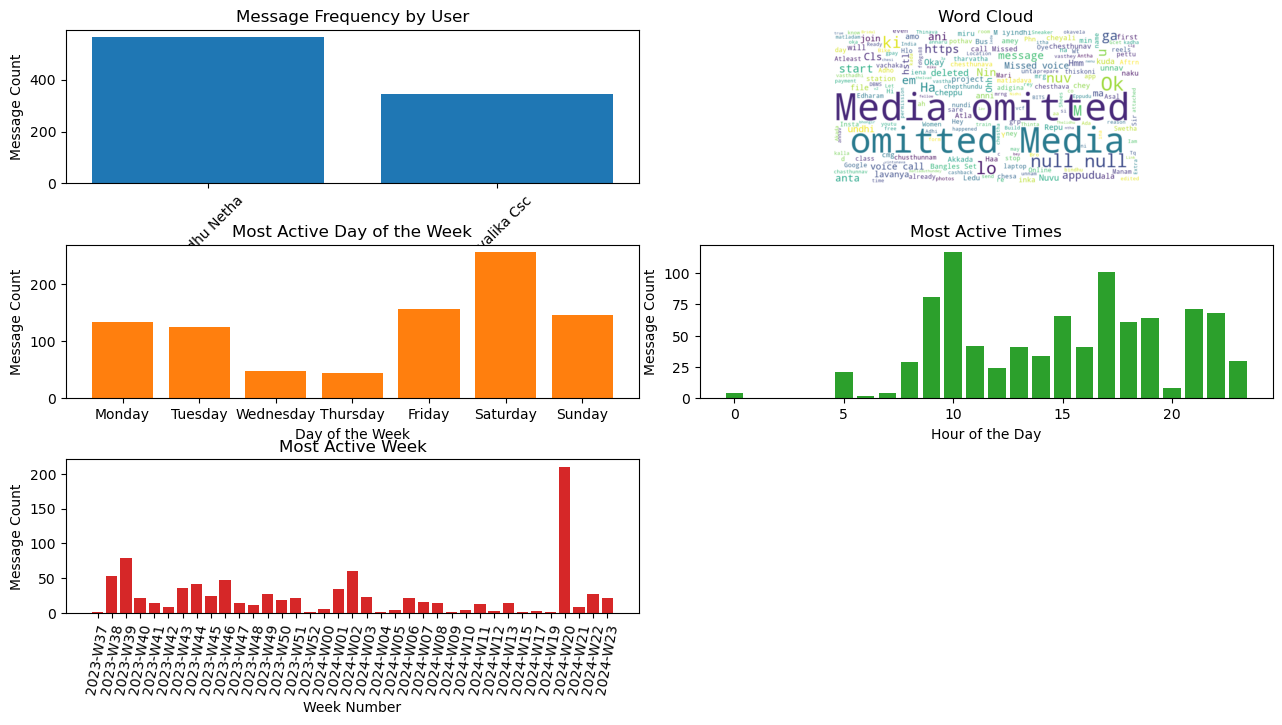

In [1]:
import tkinter as tk
from tkinter import filedialog, messagebox, ttk
import pandas as pd
import spacy
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from wordcloud import WordCloud

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

class WhatsAppNLPApp:
    def __init__(self, root):
        self.root = root
        self.root.title("WhatsApp NLP Analyzer")
        self.root.geometry("800x600")
        self.root.configure(bg="#008080")

        style = ttk.Style()
        style.configure("TButton", font=("Helvetica", 12), padding=10)
        style.configure("TLabel", font=("Helvetica", 12), padding=5, background="#f0e68c")
        style.configure("TFrame", background="#008080")
        style.configure("TText", font=("Helvetica", 10), wrap="word")
        style.configure("Header.TLabel", font=("Helvetica", 16, "bold"), padding=10)

        self.main_frame = ttk.Frame(root, padding="10 10 10 10")
        self.main_frame.grid(row=0, column=0, sticky=(tk.W, tk.E, tk.N, tk.S))
        self.main_frame.configure(style="TFrame")

        self.header_label = tk.Label(self.main_frame, text="WhatsApp NLP Analyzer", font=("Helvetica", 16, "bold"), fg="white", bg="#4CAF50", pady=10)
        self.header_label.grid(row=0, column=0, columnspan=3, pady=10, sticky=(tk.W, tk.E))

        self.load_button = tk.Button(self.main_frame, text="Load Chat File", command=self.load_file, bg="#2196F3", fg="white", font=("Helvetica", 12))
        self.load_button.grid(row=1, column=0, padx=5, pady=5, sticky=(tk.W, tk.E))

        self.analyze_button = tk.Button(self.main_frame, text="Analyze Chat", command=self.analyze_chat, bg="#FF9800", fg="white", font=("Helvetica", 12))
        self.analyze_button.grid(row=1, column=1, padx=5, pady=5, sticky=(tk.W, tk.E))
        self.analyze_button["state"] = "disabled"

        self.graph_button = tk.Button(self.main_frame, text="Graph", command=self.generate_graph, bg="#4CAF50", fg="white", font=("Helvetica", 12))
        self.graph_button.grid(row=1, column=2, padx=5, pady=5, sticky=(tk.W, tk.E))
        self.graph_button["state"] = "disabled"

        self.result_text = tk.Text(self.main_frame, wrap=tk.WORD, height=20, width=80, bg="#ffffff", fg="#000000", font=("Helvetica", 10))
        self.result_text.grid(row=2, column=0, columnspan=3, pady=10, sticky=(tk.W, tk.E))

        self.scrollbar = ttk.Scrollbar(self.main_frame, orient=tk.VERTICAL, command=self.result_text.yview)
        self.scrollbar.grid(row=2, column=3, sticky=(tk.N, tk.S, tk.E))
        self.result_text['yscrollcommand'] = self.scrollbar.set

        self.chat_data = ""

    def load_file(self):
        file_path = filedialog.askopenfilename(filetypes=[("Text files", "*.txt")])
        if file_path:
            with open(file_path, 'r', encoding='utf-8') as file:
                self.chat_data = file.read()
            messagebox.showinfo("File Loaded", "Chat file loaded successfully!")
            self.analyze_button["state"] = "normal"
            self.graph_button["state"] = "normal"

    def analyze_chat(self):
        if not self.chat_data:
            messagebox.showwarning("No Data", "Please load a chat file first!")
            return

        messages = self.parse_chat(self.chat_data)
        analyzed_data = self.perform_nlp_analysis(messages)
        self.display_results(analyzed_data)

    def parse_chat(self, chat_data):
        lines = chat_data.split("\n")
        messages = []
        for line in lines:
            if line:
                parts = line.split(" - ", 1)
                if len(parts) == 2:
                    timestamp, message = parts
                    if ": " in message:
                        user, text = message.split(": ", 1)
                        messages.append({'timestamp': timestamp, 'user': user, 'text': text})
        messages_df = pd.DataFrame(messages)
        messages_df['timestamp'] = pd.to_datetime(messages_df['timestamp'], errors='coerce')
        return messages_df

    def perform_nlp_analysis(self, messages):
        messages['nlp'] = messages['text'].apply(lambda text: nlp(text))
        messages['entities'] = messages['nlp'].apply(lambda doc: [(ent.text, ent.label_) for ent in doc.ents])
        return messages

    def display_results(self, analyzed_data):
        self.result_text.delete(1.0, tk.END)
        for idx, row in analyzed_data.iterrows():
            self.result_text.insert(tk.END, f"User: {row['user']}\n", "user")
            self.result_text.insert(tk.END, f"Text: {row['text']}\n", "text")
            self.result_text.insert(tk.END, f"Entities: {row['entities']}\n\n", "entities")

        self.result_text.tag_configure("user", foreground="#1f77b4", font=("Helvetica", 12, "bold"))
        self.result_text.tag_configure("text", foreground="#ff7f0e", font=("Helvetica", 10))
        self.result_text.tag_configure("entities", foreground="#2ca02c", font=("Helvetica", 10, "italic"))

    def generate_graph(self):
        if not self.chat_data:
            messagebox.showwarning("No Data", "Please load a chat file first!")
            return

        messages = self.parse_chat(self.chat_data)

        # Ensure valid timestamps
        messages = messages.dropna(subset=['timestamp'])

        graph_window = tk.Toplevel(self.root)

        fig, axs = plt.subplots(3, 2, figsize=(15, 15))

        # Message Frequency by User
        user_counts = messages['user'].value_counts()
        axs[0, 0].bar(user_counts.index, user_counts.values, color="#1f77b4")
        axs[0, 0].set_xlabel('Users')
        axs[0, 0].set_ylabel('Message Count')
        axs[0, 0].set_title('Message Frequency by User')
        axs[0, 0].tick_params(axis='x', rotation=45)

        # Word Cloud
        text_combined = ' '.join(messages['text'])
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_combined)
        axs[0, 1].imshow(wordcloud, interpolation='bilinear')
        axs[0, 1].axis('off')
        axs[0, 1].set_title('Word Cloud')

        # Most Active Day of the Week
        messages['day_of_week'] = messages['timestamp'].dt.day_name()
        day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        day_counts = messages['day_of_week'].value_counts().reindex(day_order, fill_value=0)
        axs[1, 0].bar(day_counts.index, day_counts.values, color="#ff7f0e")
        axs[1, 0].set_xlabel('Day of the Week')
        axs[1, 0].set_ylabel('Message Count')
        axs[1, 0].set_title('Most Active Day of the Week')

        # Analysis of Active Times
        messages['hour'] = messages['timestamp'].dt.hour
        hour_counts = messages['hour'].value_counts().sort_index()
        axs[1, 1].bar(hour_counts.index, hour_counts.values, color="#2ca02c")
        axs[1, 1].set_xlabel('Hour of the Day')
        axs[1, 1].set_ylabel('Message Count')
        axs[1, 1].set_title('Most Active Times')

        # Most Active Week
        messages['week'] = messages['timestamp'].dt.strftime('%Y-W%U')
        week_counts = messages['week'].value_counts().sort_index()
        axs[2, 0].bar(week_counts.index, week_counts.values, color="#d62728")
        axs[2, 0].set_xlabel('Week Number')
        axs[2, 0].set_ylabel('Message Count')
        axs[2, 0].set_title('Most Active Week')
        axs[2, 0].tick_params(axis='x', rotation=80)

        # Hide the empty subplot
        axs[2, 1].axis('off')

        plt.tight_layout()
        canvas = FigureCanvasTkAgg(fig, master=graph_window)
        canvas.draw()

        canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

if __name__ == "__main__":
    root = tk.Tk()
    app = WhatsAppNLPApp(root)
    root.mainloop()
